### Step 1 — Imports & helpers

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

def H2(p):
    if p <= 0.0 or p >= 1.0:
        return 0.0
    return -(p*math.log2(p) + (1-p)*math.log2(1-p))

### Step 2 — BSC simulator
Flip each bit independently with probability e, returning Y = X ⊕ noise.

In [3]:
def bsc_channel(X, e=0.1, rng=None):
    rng = np.random.default_rng(rng)
    flips = (rng.random(len(X)) < e).astype(int)
    return X ^ flips

### Step 3 — Generate input X with bias p
Generate n Bernoulli(p) bits. We will vary p ∈ (0,1).

In [4]:
def bernoulli_sequence(n, p, rng=None):
    rng = np.random.default_rng(rng)
    return (rng.random(n) < p).astype(int)

### Step 4 — Estimate I(X;Y) from samples
Compute joint counts over (x,y)∈{0,1}×{0,1}, then marginals, then I(X;Y)=∑ p(x,y)
log2[p(x,y)/(p(x)p(y))].

In [5]:
def mutual_information_binary(X, Y):
    # joint counts
    c = np.zeros((2,2), dtype=int)
    for a,b in zip(X,Y):
        c[a,b] += 1
    n = c.sum()
    pxy = c / n
    px = pxy.sum(axis=1, keepdims=True) # shape (2,1)
    py = pxy.sum(axis=0, keepdims=True) # shape (1,2)
    I = 0.0
    for i in [0,1]:
        for j in [0,1]:
            if pxy[i,j] > 0 and px[i,0] > 0 and py[0,j] > 0:
                I += pxy[i,j] * math.log2(pxy[i,j] / (px[i,0]*py[0,j]))
    return I

### Step 5 — For fixed e, sweep p and find I* = max_p I(X;Y)
Use a fine grid of p values to approximate the maximizer and the empirical capacity.

In [6]:
def empirical_capacity_bsc(e, n=200_000, p_grid=None, rng_seed=0):
    if p_grid is None:
        p_grid = np.linspace(0.01, 0.99, 99)
    rng = np.random.default_rng(rng_seed)
    best_I, best_p = -1.0, None
    for p in p_grid:
        X = (rng.random(n) < p).astype(int)
        Y = bsc_channel(X, e=e, rng=rng)
        I = mutual_information_binary(X, Y)
        if I > best_I:
            best_I, best_p = I, p
    return best_I, best_p

# Example at e=0.1
I_star, p_star = empirical_capacity_bsc(e=0.1, n=100_000, rng_seed=1)
C_theory = 1 - H2(0.1)
print(f"e=0.1 I*≈{I_star:.4f} bits @ p≈{p_star:.2f} | Theory C=1-H2(e)={C_theory:.4f}")

e=0.1 I*≈0.5330 bits @ p≈0.51 | Theory C=1-H2(e)=0.5310


### Step 6 — Plot empirical I(X;Y) vs p for a chosen e
Visualize how input bias affects mutual information; the maximum should occur near p=0.5 for a
BSC.

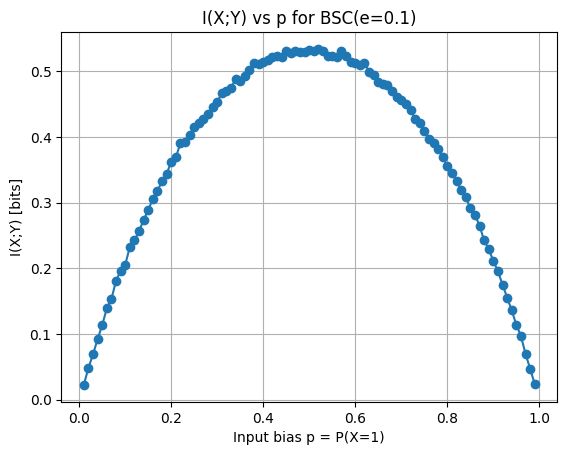

In [7]:
def plot_I_vs_p(e=0.1, n=100_000):
    ps = np.linspace(0.01, 0.99, 99)
    rng = np.random.default_rng(0)
    Is = []
    for p in ps:
        X = (rng.random(n) < p).astype(int)
        Y = bsc_channel(X, e=e, rng=rng)
        Is.append(mutual_information_binary(X, Y))
    plt.figure()
    plt.plot(ps, Is, marker='o')
    plt.xlabel('Input bias p = P(X=1)')
    plt.ylabel('I(X;Y) [bits]')
    plt.title(f'I(X;Y) vs p for BSC(e={e})')
    plt.grid(True)
    plt.show()

plot_I_vs_p(e=0.1, n=80_000)

### Step 7 — Capacity vs e: empirical vs theory
Sweep e ∈ [0,0.5] and compare the empirical capacity (max over p) with the theoretical curve
1−H2(e).

In [ ]:
def capacity_curve(n=120_000):
    es = np.linspace(0.0, 0.5, 11)
    emp_C = []
    th_C = []
    for e in es:
        I_star, _ = empirical_capacity_bsc(e, n=n, rng_seed=123)
        emp_C.append(I_star)
        th_C.append(1 - H2(e))
    # Plot
    plt.figure()
    plt.plot(es, emp_C, marker='o', label='Empirical max I(X;Y)')
    plt.plot(es, th_C, marker='x', label='Theory 1 − H2(e)')
    plt.xlabel('Flip probability e')
    plt.ylabel('Capacity [bits/channel use]')
    plt.title('BSC Capacity: Empirical vs Theory')
    plt.grid(True)
    plt.legend()
    plt.show()
    # Print a few numeric comparisons
    for e, ce, ct in zip(es, emp_C, th_C):
        print(f"e={e:.2f} Empirical≈{ce:.4f} Theory={ct:.4f} Δ={ce-ct:+.4f}")

capacity_curve(n=80_000)